# Convert and Optimize RT-DETR  real-time object detection with OpenVINO™

Real-time object detection is often used as a key component in computer vision systems. Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.

This tutorial demonstrates step-by-step instructions on how to run and optimize RT-DETR with OpenVINO. We consider the steps required for object detection scenario.

## Install the Operating Environment
In order to make it easier for everyone to reproduce the project, we first set up the project running environment, mainly including the PaddlePaddle model acquisition environment and the OpenVINO model optimization environment.

### Install PaddlePaddle Environment
The RT-DETR model is trained under the PaddlePaddle framework, so in order to export the model in the future, we need to install the PaddlePaddle environment. Here, only the CPU environment needs to be installed, and there is no need to install the GPU environment.
- Install PaddlePaddle

In [1]:
!python -m pip install paddlepaddle>=2.4.1 -i https://pypi.tuna.tsinghua.edu.cn/simple

- Install PaddleDetection

In [ ]:
# Clone PaddleDetection repository
!git clone https://github.com/PaddlePaddle/PaddleDetection.git

In [ ]:
# Install other dependencies
%cd PaddleDetection
!git checkout develop
%pip install -r requirements.txt
# Compile and install paddledet
!python setup.py install
%cd ..

- Install ONNX

In [ ]:
%pip install onnx==1.13.0
%pip install paddle2onnx==1.0.5

### Install OpenVINO Environment

In [ ]:
%pip install -q "openvino>=2023.1.0" "nncf>=2.5.0"

### Install ultralytics Environment
The RT-DETR model is trained based on the COCO dataset, so here we use the Ultratics toolkit for dataset processing.

In [ ]:
%pip install -q "ultralytics==8.0.43" onnx --extra-index-url https://download.pytorch.org/whl/cpu

### Download the notebook_utils
Download to ".\optimize"

In [12]:
# If the current file path is not in the specified folder, please switch to the specified folder.
# %cd .. 
# Fetch the notebook utils script from the openvino_notebooks repo
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

('notebook_utils.py', <http.client.HTTPMessage at 0x2149490bac0>)

In [ ]:
%pip install ipywidgets

### Load All Environments

In [46]:
import os
import PIL
import torch
import nncf


import numpy as np
import openvino as ov
import cv2 as cv


import ipywidgets as widgets

from openvino.runtime import serialize

from zipfile import ZipFile
from tqdm.notebook import tqdm
from pathlib import Path
from typing import Dict
from PIL import ImageDraw, Image

from notebook_utils import download_file
from pathlib import Path

from ultralytics.yolo.utils.metrics import ConfusionMatrix
from ultralytics.yolo.utils import ops
from ultralytics import YOLO
from ultralytics.yolo.utils import DEFAULT_CFG
from ultralytics.yolo.cfg import get_cfg
from ultralytics.yolo.data.utils import check_det_dataset

## Download RT-DETR model
- Select the Model

    First, select the model you want to download.

In [ ]:
MODEL_NAME = widgets.Dropdown(
    options= ["rtdetr_r101vd_6x"]+["rtdetr_r50vd_m_6x"]+["rtdetr_r50vd_6x"]+["rtdetr_r34vd_6x"]+["rtdetr_r18vd_6x"],
    value='rtdetr_r50vd_6x',
    description='Model name:',
    disabled=False,
)
MODEL_NAME

- Download Paddlepaddle Model

    If the PaddlePaddle installed is a CPU version, it is necessary to modify the "runtime.yml" file in the ".\optimize\PaddleDetection\configs" path, as shown in the following figure: 
    
    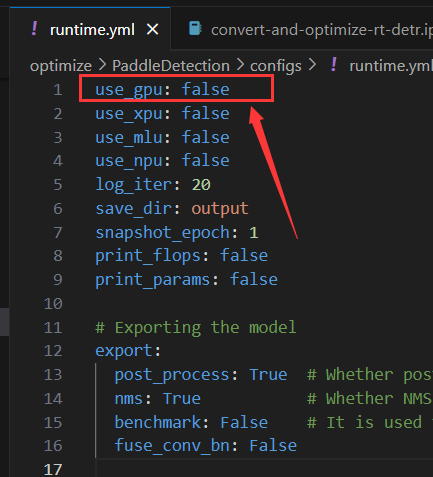

    The default exported model is a multi input model with post-processing. We need to export a single input model, so we need to modify the "rtdetr_r50vd.yml" file under the ".\optimize\PaddleDetection\configs\rtdetr\\\_base_" path, as shown in the following figure:

    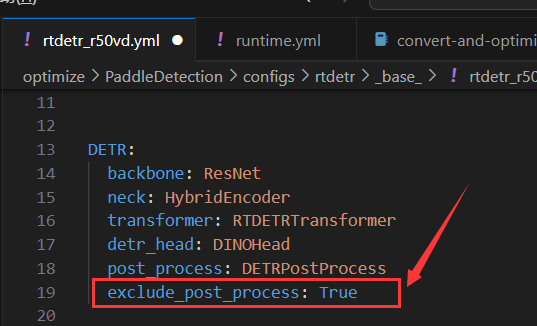

    Then enter the following command to export the PaddlePaddle model.

In [48]:
select_model=MODEL_NAME.value+"_coco"
config=f"PaddleDetection/configs/rtdetr/{MODEL_NAME.value}_coco.yml"
if select_model=='rtdetr_r34vd_6x_coco':
    url=f"https://bj.bcebos.com/v1/paddledet/models/rtdetr_r34vd_dec4_6x_coco.pdparams"
elif select_model=='rtdetr_r18vd_6x_coco':
    url=f"https://bj.bcebos.com/v1/paddledet/models/rtdetr_r18vd_dec3_6x_coco.pdparams"
else :
    url=f"https://bj.bcebos.com/v1/paddledet/models/{select_model}.pdparams"

In [ ]:
!python PaddleDetection/tools/export_model.py -c {config} -o weights={url} trt=True --output_dir=PaddleDetection/output_inference

- Convert model to ONNX

We need to convert the model to IR format. The traditional approach is to first convert the PaddlePaddle model to ONNX format, and then convert the model to IR format; Of course, the latest version of OpenVINO supports direct conversion of PaddlPallde, and we can skip this step and proceed directly to the next step.
I use the traditional process here: PaddlePaddle ->ONNX ->IR

In [ ]:
model_dir=f"./PaddleDetection/output_inference/{select_model}/"
save_file=f"./models/{select_model}.onnx"
!paddle2onnx --model_dir={model_dir} --model_filename model.pdmodel --params_filename model.pdiparams --opset_version 16 --save_file {save_file}

- Convert model to OpenVINO IR

The IR model conversion can be achieved through Python code, and one can be achieved through commands. Here, we use commands for conversion:

In [51]:
onnx_model_path=save_file
output_model=f"./models/{select_model}"
!ovc {onnx_model_path} --output_model {output_model}

[ INFO ] Generated IR will be compressed to FP16. If you get lower accuracy, please consider disabling compression by removing argument "compress_to_fp16" or set it to false "compress_to_fp16=False".
Find more information about compression to FP16 at https://docs.openvino.ai/2023.0/openvino_docs_MO_DG_FP16_Compression.html
[ SUCCESS ] XML file: ./models/rtdetr_r34vd_6x_coco.xml
[ SUCCESS ] BIN file: ./models/rtdetr_r34vd_6x_coco.bin


## Test Original Model Inference

### Model Data Process
Define the RT-DETR model data processing method.

In [52]:
def print_info(msg):
    print("[INFO]  %s"%msg,end="\n")
    
# The `RtdetrProcess` class is a Python class that provides methods for preprocessing and
# postprocessing images for the RT-DETR object detection model.
class RtdetrProcess(object):
    def __init__(self, target_size, label_path=None, threshold=0.5, interp=cv.INTER_LINEAR):
        self.im_info = dict()
        self.target_size =target_size
        self.interp = interp
        self.threshold = threshold
        if label_path is None:
            self.labels = []
            self.flabel = False
        else:
            self.labels = self.read_lable(label_path=label_path)
            self.flabel = True

    def read_lable(self,label_path):
        lable = [] 
        f = open(label_path)
        line = f.readline()
        while line:
            lable.append(line.replace('\n',''))
            line = f.readline()
        f.close()
        return lable
    def preprocess(self,im):
        assert len(self.target_size) == 2
        assert self.target_size[0] > 0 and self.target_size[1] > 0
        origin_shape = im.shape[:2]
        resize_h, resize_w = self.target_size
        im_scale_y = resize_h / float(origin_shape[0])
        im_scale_x = resize_w / float(origin_shape[1])
        out_im = cv.cvtColor(im,cv.COLOR_BGR2RGB)
        out_im = cv.resize(
            out_im.astype('float32'),
            None,
            None,
            fx=im_scale_x,
            fy=im_scale_y,
            interpolation=self.interp)
        self.im_info['im_shape'] = np.array(im.shape[:2]).astype('float32')
        self.im_info['scale_factor'] = np.array([im_scale_y, im_scale_x]).astype('float32')
        scale = 1.0 / 255.0
        out_im *= scale
        out_im = out_im.transpose((2, 0, 1)).copy()

        return  np.expand_dims(out_im.astype('float32'),0), self.im_info
    
    def sigmoid(self,z):
        fz = []
        for num in z:
            fz.append(1/(1+np.exp(-num)))
        return np.array(fz)
    def postprocess(self,scores,bboxs=None):
        results = []
        if bboxs is None:
            scores = np.array(scores).astype('float32')
            for l in scores:
                if(l[1]>=self.threshold):
                    re = dict()
                    re["clsid"]=int(l[0])
                    if(self.flabel):
                        re["label"]=self.labels[int(l[0])]
                    else:
                        re["label"]=int(l[0])
                    re["score"]=l[1]
                    bbox=[l[2],l[3],l[4],l[5]]
                    re["bbox"]=bbox
                    results.append(re)
        else:
            scores = np.array(scores).astype('float32')
            bboxs = np.array(bboxs).astype('float32')
            for s,b in zip(scores,bboxs):
                s = self.sigmoid(s)
                if(np.max(np.array(s)>=self.threshold)):
                    ids = np.argmax(np.array(s))
                    re = dict()
                    re["clsid"]=int(ids)
                    if(self.flabel):
                        re["label"]=self.labels[int(ids)]
                    else:
                        re["label"]=int(ids)
                    re["score"]=s[ids]
                    cx=(b[0]*640.0)/self.im_info["scale_factor"][1]
                    cy=(b[1]*640.0)/self.im_info["scale_factor"][0]
                    w=(b[2]*640.0)/self.im_info["scale_factor"][1]
                    h=(b[3]*640.0)/self.im_info["scale_factor"][0]

                    bbox=[cx-w/2.0,
                          cy-h/2.0,
                          cx+w/2.0,
                          cy+h/2.0]
                    re["bbox"]=bbox
                    results.append(re)
        return results
    def get_color_map_list(self, num_classes):
        color_map = num_classes * [0, 0, 0]
        for i in range(0, num_classes):
            j = 0
            lab = i
            while lab:
                color_map[i * 3] |= (((lab >> 0) & 1) << (7 - j))
                color_map[i * 3 + 1] |= (((lab >> 1) & 1) << (7 - j))
                color_map[i * 3 + 2] |= (((lab >> 2) & 1) << (7 - j))
                j += 1
                lab >>= 3
        color_map = [color_map[i:i + 3] for i in range(0, len(color_map), 3)]
        return color_map
    def imagedraw_textsize_c(self, draw, text):
        """
        The function `imagedraw_textsize_c` calculates the width and height of a given text when drawn on an
        image using the `draw` object.
        
        Args:
          draw: The "draw" parameter is an instance of the `ImageDraw` class from the PIL library. It is
        used to draw on an image.
          text: The "text" parameter is the string of text that you want to measure the size of.
        
        Returns:
          the width (tw) and height (th) of the text when it is drawn on an image.
        """
        if int(PIL.__version__.split('.')[0]) < 10:
            tw, th = draw.textsize(text)
        else:
            left, top, right, bottom = draw.textbbox((0, 0), text)
            tw, th = right - left, bottom - top

        return tw, th
    def draw_box(self, im, results):
        draw_thickness = 2
        im = Image.fromarray(im)
        draw = ImageDraw.Draw(im)
        clsid2color = {}
        color_list = self.get_color_map_list(80)
        for re in results:
            clsid =  re["clsid"]
            label = re["label"]
            bbox = re["bbox"]
            score = re["score"]
            if clsid not in clsid2color:
                clsid2color[clsid] = color_list[clsid]
            color = tuple(clsid2color[clsid])

            if len(bbox) == 4:
                xmin, ymin, xmax, ymax = bbox
                print_info('class_id:{:d}, label:{:s}, confidence:{:.4f}, left_top:[{:.2f},{:.2f}],'
                    'right_bottom:[{:.2f},{:.2f}]'.format(
                        int(clsid), label, score, xmin, ymin, xmax, ymax))
                # draw bbox
                draw.line(
                    [(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin),
                    (xmin, ymin)],
                    width=draw_thickness,
                    fill=color)
            elif len(bbox) == 8:
                x1, y1, x2, y2, x3, y3, x4, y4 = bbox
                draw.line(
                    [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x1, y1)],
                    width=2,
                    fill=color)
                xmin = min(x1, x2, x3, x4)
                ymin = min(y1, y2, y3, y4)

            # draw label
            text = "{} {:.4f}".format(label, score)
            tw, th = self.imagedraw_textsize_c(draw, text)
            draw.rectangle(
                [(xmin + 1, ymin - th), (xmin + tw + 1, ymin)], fill=color)
            draw.text((xmin + 1, ymin - th), text, fill=(255, 255, 255))
        return np.array(im)



### Model Inference Process
Define the RT-DETR model inference process to achieve model inference and result processing.

In [53]:
def rtdert_infer(model:ov.Model, core:ov.Core, image_path, device_name, lable_path):
    '''-------------------1. Initialize and Read Model ----------------------'''
    print_info("Device name: " + device_name)
    
    compiled_model = core.compile_model(model=model, device_name=device_name)

    '''-------------------2. Preprocessing model input data ----------------------'''
    print_info("The input path: " + image_path)
    image = cv.imread(image_path)
    rtdetr_process = RtdetrProcess([640,640],lable_path)
    im, im_info= rtdetr_process.preprocess(image)
    inputs = dict()
    inputs["image"] = np.array(im).astype('float32')
    
    '''-------------------3. Infer ----------------------'''
    results = compiled_model(inputs=inputs)
    '''-------------------5. Post processing prediction results ----------------------'''

    
    re=rtdetr_process.postprocess(results[compiled_model.output(1)][0],results[compiled_model.output(0)][0])
    new_image=rtdetr_process.draw_box(image,re)
    return new_image


### Implement Model Inference

[INFO]  Device name: CPU
[INFO]  The input path: ./../image/000000570688.jpg
[INFO]  class_id:0, label:person, confidence:0.8688, left_top:[402.46,346.26],right_bottom:[456.32,480.07]
[INFO]  class_id:0, label:person, confidence:0.9037, left_top:[215.08,328.18],right_bottom:[258.36,469.82]
[INFO]  class_id:33, label:kite, confidence:0.8279, left_top:[323.27,159.75],right_bottom:[466.73,214.74]
[INFO]  class_id:0, label:person, confidence:0.8739, left_top:[259.58,343.64],right_bottom:[300.03,462.55]
[INFO]  class_id:33, label:kite, confidence:0.8218, left_top:[330.05,64.39],right_bottom:[389.91,86.09]
[INFO]  class_id:33, label:kite, confidence:0.8446, left_top:[282.12,217.19],right_bottom:[418.61,267.34]
[INFO]  class_id:0, label:person, confidence:0.8146, left_top:[519.37,360.84],right_bottom:[581.73,479.35]
[INFO]  class_id:0, label:person, confidence:0.7486, left_top:[310.74,384.01],right_bottom:[356.62,442.31]
[INFO]  class_id:33, label:kite, confidence:0.8057, left_top:[221.43,264

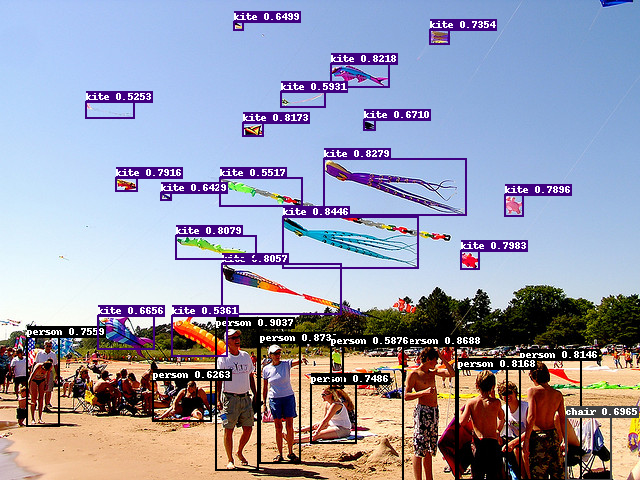

In [54]:
core = ov.Core()
rtdetr_model = core.read_model(f'./models/{select_model}.xml')
image=rtdert_infer(rtdetr_model, core, "./../image/000000570688.jpg", "CPU","./../image/COCO_lable.txt")
Image.fromarray(cv.cvtColor(image,cv.COLOR_BGR2RGB))

## Preparing the Validate Dataset

### Download the Validation COCO Dataset
RT-DETR is pre-trained on the COCO dataset, so to evaluate the model accuracy we need to download it. According to the instructions provided in the RT-DETR repo, we also need to download annotations in the format used by the author of the model, for use with the original model evaluation function.

> Note: The initial dataset download may take a few minutes to complete. The download speed will vary depending on the quality of your internet connection.

In [55]:
DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"
CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/8ebe94d1e928687feaa1fee6d5668987df5e43be/ultralytics/datasets/coco.yaml"

OUT_DIR = Path('./datasets')

DATA_PATH = OUT_DIR / "val2017.zip"
LABELS_PATH = OUT_DIR / "coco2017labels-segments.zip"
CFG_PATH = OUT_DIR / "coco.yaml"
CACHE_PATH = OUT_DIR / "coco/labels/val2017.cache"


In [ ]:
# download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
# download_file(LABELS_URL, LABELS_PATH.name, LABELS_PATH.parent)
download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(LABELS_PATH , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(DATA_PATH , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')


### Configure Validator helper and create DataLoader

The Yolov8 model repository uses a Validator wrapper, which represents the accuracy validation pipeline. It creates dataloader and evaluation metrics and updates metrics on each data batch produced by the dataloader. Besides that, it is responsible for data preprocessing and results postprocessing. 
The RT-DETR model training set also uses the COCO dataset. For convenience, we use the Yolov8 environment to configure the data here.
For class initialization, the configuration should be provided. We will use the default setup, but it can be replaced with some parameters overriding to test on custom data. The model has connected the ValidatorClass method, which creates a validator class instance.

In [56]:
args = get_cfg(cfg=DEFAULT_CFG)
args.data = str(CFG_PATH)

In [57]:
YOLO_MODEL = "yolov8n"
models_dir = Path('./models')
yolo_model = YOLO(models_dir / f'{YOLO_MODEL}.pt')
det_validator = yolo_model.ValidatorClass(args=args)

In [59]:
det_validator.data = check_det_dataset(args.data)
det_data_loader = det_validator.get_dataloader("./datasets/coco", 1)

val: Scanning datasets\coco\labels\val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


In [60]:
det_validator.is_coco = True
det_validator.class_map = ops.coco80_to_coco91_class()
det_validator.names = yolo_model.model.names
det_validator.metrics.names = det_validator.names
det_validator.nc = yolo_model.model.model[-1].nc

## Check Model Accuracy on the Dataset

For comparing the optimized model result with the original, it is good to know some measurable results in terms of model accuracy on the validation dataset.

### Define validation function

In [61]:

def sigmoid(z):
    return 1/(1+np.exp(-z))

def rtdetr_result(preds_box,preds_score):
    results=[]
    n=0
    for i in range(300):
        scores=preds_score[0,i,:]
        score=sigmoid(np.max(np.array(scores)))
        if(score<0.0001):
            continue
        result=[]
        cx=preds_box[0,i,0]*640.0
        cy=preds_box[0,i,1]*640.0
        w=preds_box[0,i,2]*640.0
        h=preds_box[0,i,3]*640.0
        result.append(cx-0.5*w)
        result.append(cy-0.5*h)
        result.append(cx+0.5*w)
        result.append(cy+0.5*h)
        result.append(score)
        result.append(np.argmax(scores))
        results.append(result)
        n+=1
    # _, indices = torch.sort(torch.tensor(results), descending=True, dim=0)
    # re=[]
    # for i in range(n):
    #     re.append(results[indices[:,4][i]])
    return [torch.tensor(results)]

def test(model:ov.Model, core:ov.Core, data_loader:torch.utils.data.DataLoader, validator, num_samples:int = None):
    """
    OpenVINO RT-DETR model accuracy validation function. Runs model validation on dataset and returns metrics
    Parameters:
        model (Model): OpenVINO model
        data_loader (torch.utils.data.DataLoader): dataset loader
        validator: instance of validator class
        num_samples (int, *optional*, None): validate model only on specified number samples, if provided
    Returns:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
    """
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.batch_i = 1
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    compiled_model = core.compile_model(model)
    for batch_i, batch in enumerate(tqdm(data_loader, total=num_samples)):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        results = compiled_model(batch["img"])
        preds_box = torch.from_numpy(results[compiled_model.output(0)])
        preds_score = torch.from_numpy(results[compiled_model.output(1)])
        
        preds=rtdetr_result(preds_box,preds_score)
        # print(batch)
        # print(preds[0])
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    return stats

def print_stats(stats:np.ndarray, total_images:int, total_objects:int):
    """
    Helper function for printing accuracy statistic
    Parameters:
        stats: (Dict[str, float]) - dictionary with aggregated accuracy metrics statistics, key is metric name, value is metric value
        total_images (int) -  number of evaluated images
        total objects (int)
    Returns:
        None
    """
    print("Boxes:")
    mp, mr, map50, mean_ap = stats['metrics/precision(B)'], stats['metrics/recall(B)'], stats['metrics/mAP50(B)'], stats['metrics/mAP50-95(B)']
    # Print results
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
    print(s)
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', total_images, total_objects, mp, mr, map50, mean_ap))
    if 'metrics/precision(M)' in stats:
        s_mp, s_mr, s_map50, s_mean_ap = stats['metrics/precision(M)'], stats['metrics/recall(M)'], stats['metrics/mAP50(M)'], stats['metrics/mAP50-95(M)']
        # Print results
        s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'Precision', 'Recall', 'mAP@.5', 'mAP@.5:.95')
        print(s)
        pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
        print(pf % ('all', total_images, total_objects, s_mp, s_mr, s_map50, s_mean_ap))

### Select inference device

Select device from dropdown list for running inference using OpenVINO

In [ ]:
core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

### Read Inference Model

In [63]:
det_model_path=f'./models/{MODEL_NAME.value}_coco.xml'
det_ov_model = core.read_model(det_model_path)
if device.value != "CPU":
    det_ov_model.reshape({0: [1, 3, 640, 640]})

### Getting Accuracy Metrics

After definition test function and validator creation, we are ready for getting accuracy metrics

> Note: Model evaluation is time consuming process and can take several minutes, depending on the hardware. For reducing calculation time, we define num_samples parameter with evaluation subset size, but in this case, accuracy can be noncomparable with originally reported by the authors of the model, due to validation subset difference.

To validate the models on the full dataset set NUM_TEST_SAMPLES = None.

In [64]:
NUM_TEST_SAMPLES = 50

In [ ]:
fp_det_stats = test(det_ov_model, core, det_data_loader, det_validator, num_samples=NUM_TEST_SAMPLES)

In [66]:
print_stats(fp_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

Boxes:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all          50         362       0.681       0.551       0.623       0.494


print_stats reports the following list of accuracy metrics:

- **Precision** is the degree of exactness of the model in identifying only relevant objects.
- **Recall** measures the ability of the model to detect all ground truths objects.
- **mAP@t** - mean average precision, represented as area under the Precision-Recall curve aggregated over all classes in the dataset, where t is the Intersection Over Union (IOU) threshold, degree of overlapping between ground truth and predicted objects. Therefore, **mAP@.5** indicates that mean average precision is calculated at 0.5 IOU threshold, **mAP@.5:.95** - is calculated on range IOU thresholds from 0.5 to 0.95 with step 0.05.

## Optimize model using NNCF Post-training Quantization API

NNCF provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop. We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize RT-DETR.

The optimization process contains the following steps:

Create a Dataset for quantization.
Run nncf.quantize for getting an optimized model.
Serialize OpenVINO IR model, using the openvino.runtime.serialize function.
Reuse validation dataloader in accuracy testing for quantization. For that, it should be wrapped into the nncf.Dataset object and define a transformation function for getting only input tensors.

In [67]:
def transform_fn(data_item:Dict):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Dict with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = det_validator.preprocess(data_item)['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(det_data_loader, transform_fn)

The nncf.quantize function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope, etc.) can be provided.

> Note: Model post-training quantization is time-consuming process. Be patient, it can take several minutes depending on your hardware.

In [68]:
# Detection model
quantized_det_model = nncf.quantize(
    det_ov_model,
    quantization_dataset,
    preset=nncf.QuantizationPreset.MIXED
)

Statistics collection:  11%|█         | 32/300 [00:24<03:24,  1.31it/s]

In [38]:
int8_model_det_path = models_dir / f'rtdetr_openvino_int8_model/{select_model}.xml'
print(f"Quantized detection model will be saved to {int8_model_det_path}")
serialize(quantized_det_model, str(int8_model_det_path))

Quantized detection model will be saved to models\rtdetr_openvino_int8_model\rtdetr_r50vd_m_6x_coco.xml


## Validate Quantized model inference
nncf.quantize returns the OpenVINO Model class instance, which is suitable for loading on a device for making predictions. INT8 model input data and output result formats have no difference from the floating point model representation. Therefore, we can reuse the same detect function defined above for getting the INT8 model result on the image.

[INFO]  Device name: CPU
[INFO]  The input path: ./../image/000000570688.jpg
[INFO]  class_id:0, label:person, confidence:0.8998, left_top:[402.31,344.90],right_bottom:[455.44,479.48]
[INFO]  class_id:0, label:person, confidence:0.8036, left_top:[457.23,368.23],right_bottom:[509.00,478.72]
[INFO]  class_id:0, label:person, confidence:0.9155, left_top:[215.29,326.88],right_bottom:[260.00,468.97]
[INFO]  class_id:0, label:person, confidence:0.8478, left_top:[520.85,361.69],right_bottom:[581.67,479.59]
[INFO]  class_id:33, label:kite, confidence:0.8477, left_top:[330.40,65.12],right_bottom:[389.71,87.07]
[INFO]  class_id:33, label:kite, confidence:0.7982, left_top:[175.72,236.65],right_bottom:[257.44,258.66]
[INFO]  class_id:33, label:kite, confidence:0.7105, left_top:[221.44,262.87],right_bottom:[344.63,312.14]
[INFO]  class_id:33, label:kite, confidence:0.9174, left_top:[283.04,216.58],right_bottom:[420.20,266.36]
[INFO]  class_id:0, label:person, confidence:0.6807, left_top:[29.04,340.

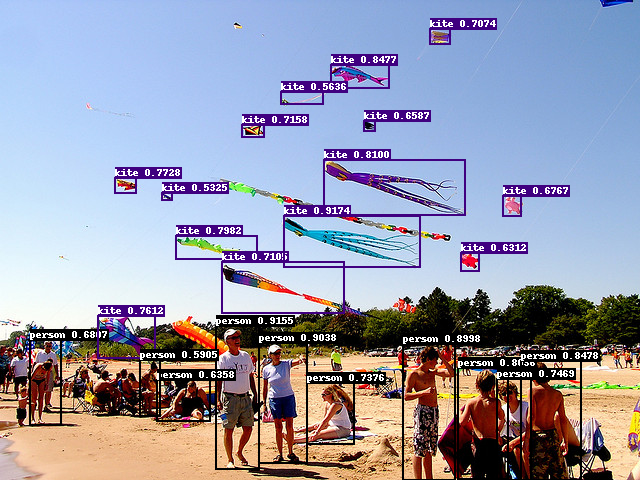

In [39]:
image=rtdert_infer(quantized_det_model, core, "./../image/000000570688.jpg", "CPU","./../image/COCO_lable.txt")
Image.fromarray(cv.cvtColor(image,cv.COLOR_BGR2RGB))

## Compare the Original and Quantized Models

### Compare performance object detection models

Finally, use the OpenVINO Benchmark Tool to measure the inference performance of the FP32 and INT8 models.

Note: For more accurate performance, it is recommended to run benchmark_app in a terminal/command prompt after closing other applications. Run benchmark_app -m <model_path> -d CPU -shape "<input_shape>" to benchmark async inference on CPU on specific input data shape for one minute. Change CPU to GPU to benchmark on GPU. Run benchmark_app --help to see an overview of all command-line options.

In [40]:
device

Dropdown(description='Device:', options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='CPU')

In [41]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m {det_model_path} -d {device.value} -api async -shape "[1,3,640,640]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.1.0-12185-9e6b00e51cd-releases/2023/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.1.0-12185-9e6b00e51cd-releases/2023/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 77.73 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     image (node: image) : f32 / [...] / [?,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     stack_4.tmp_0_slice_0 (node: stack_4.tmp_0_slice_0) : f32 / [...] / [?,300,4]
[ INFO ]     stack_5.tmp_0_slice_0 (node: stack_5.tmp_0_slice_0) : f32 / [...] / [?,30

In [42]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m {int8_model_det_path} -d {device.value} -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2023.1.0-12185-9e6b00e51cd-releases/2023/1
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2023.1.0-12185-9e6b00e51cd-releases/2023/1
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 119.19 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     image (node: image) : f32 / [...] / [?,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     stack_4.tmp_0_slice_0 (node: stack_4.tmp_0_slice_0) : f32 / [...] / [?,300,4]
[ INFO ]     stack_5.tmp_0_slice_0 (node: stack_5.tmp_0_slice_0) : f32 / [...] / [?,3

### Validate quantized model accuracy
As we can see, there is no significant difference between INT8 and float model result in a single image test. To understand how quantization influences model prediction precision, we can compare model accuracy on a dataset.

In [43]:
int8_det_stats = test(quantized_det_model, core, det_data_loader, det_validator, num_samples=NUM_TEST_SAMPLES)

  0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
print("FP32 model accuracy")
print_stats(fp_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

print("INT8 model accuracy")
print_stats(int8_det_stats, det_validator.seen, det_validator.nt_per_class.sum())

FP32 model accuracy
Boxes:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all          50         362       0.688       0.576       0.664       0.531
INT8 model accuracy
Boxes:
               Class      Images      Labels   Precision      Recall      mAP@.5  mAP@.5:.95
                 all          50         362       0.679       0.602        0.66       0.509


The accuracy of the model prediction has changed, but the change is small and meets the quantitative standards.